# Bat vs Rat — Seasonal Change

This notebook loads `dataset1.csv` and `dataset2.csv` and produces charts, regression

>

In [23]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

In [24]:
df1 = pd.read_csv("dataset1.csv", parse_dates=["start_time","rat_period_start","rat_period_end"])
df2 = pd.read_csv("dataset2.csv", parse_dates=["time"])

In [25]:
print("DF1", df1.shape)
print("DF2", df2.shape)

DF1 (907, 12)
DF2 (2123, 7)


In [26]:
for col in ["bat_landing_to_food","seconds_after_rat_arrival","hours_after_sunset","reward","risk"]:
    if col in df1.columns:
        df1[col] = pd.to_numeric(df1[col], errors="coerce")

for col in ["rat_arrival_number","rat_minutes","bat_landing_number","food_availability","hours_after_sunset"]:
    if col in df2.columns:
        df2[col] = pd.to_numeric(df2[col], errors="coerce")

In [27]:
df1["rat_present_at_landing"] = ((df1["start_time"] >= df1["rat_period_start"]) & (df1["start_time"] <= df1["rat_period_end"])).astype(int)

In [28]:
print("\nrat_present_at_landing counts:")
df1["rat_present_at_landing"].value_counts()


rat_present_at_landing counts:


rat_present_at_landing
1    907
Name: count, dtype: int64

In [29]:
df2 = df2.sort_values("time").copy()
df2["period_start"] = df2["time"]
df2["period_end"] = df2["time"] + pd.Timedelta(minutes=30)

In [30]:
def find_period_start(ts, periods=df2[["period_start","period_end"]]):
    match = periods[(periods["period_start"] <= ts) & (ts < periods["period_end"])]
    return match.iloc[0]["period_start"] if not match.empty else pd.NaT

In [31]:
df1["period_start"] = df1["start_time"].apply(find_period_start)
df = df1.merge(df2, on="period_start", how="left", suffixes=("","_period"))

In [32]:
df["rat_minutes"] = df["rat_minutes"].fillna(0)
nonzero = df.loc[df["rat_minutes"]>0, "rat_minutes"]
if len(nonzero) >= 5:
    q = nonzero.quantile([0.33,0.66]).values
    def rat_group(v):
        if v==0: return "none"
        if v <= q[0]: return "low"
        if v <= q[1]: return "medium"
        return "high"
    df["rat_activity_group"] = df["rat_minutes"].apply(rat_group)
else:
    df["rat_activity_group"] = df["rat_minutes"].apply(lambda v: "none" if v==0 else "some")

In [33]:
df["rat_activity_group"].value_counts()

rat_activity_group
high      309
low       301
medium    297
Name: count, dtype: int64

In [34]:
print("\nOverview:")
print({
    "n_landings": len(df),
    "n_periods": len(df2),
    "total_rat_minutes": df["rat_minutes"].sum(),
    "total_rat_arrivals": df2["rat_arrival_number"].sum()
})


Overview:
{'n_landings': 907, 'n_periods': 2123, 'total_rat_minutes': 9257.683333322, 'total_rat_arrivals': 944}


In [35]:
print("\nRisk by rat activity group:")
risk_tab = df.groupby("rat_activity_group")["risk"].agg(["count","sum","mean"]).rename(columns={"sum":"n_risk","mean":"risk_rate"})
print(risk_tab)


Risk by rat activity group:
                    count  n_risk  risk_rate
rat_activity_group                          
high                  309     155   0.501618
low                   301     162   0.538206
medium                297     132   0.444444


In [36]:
print("\nHesitation (bat_landing_to_food) by rat activity group:")
hes_tab = df.groupby("rat_activity_group")["bat_landing_to_food"].describe()
hes_tab


Hesitation (bat_landing_to_food) by rat activity group:


,count,mean,std,min,25%,50%,75%,max
rat_activity_group,,,,,,,,
high,309.0,15.325050,37.004313,0.010871,1.0,4.0,14.0,443.0
low,301.0,9.299052,17.914143,0.014004,1.0,4.0,10.0,174.0
medium,297.0,10.401876,23.827650,0.010238,1.0,4.0,11.0,237.0


In [37]:
tests = {}

# Risk-taking: z-test (any rat vs none)
any_rat = df["rat_minutes"] > 0
counts = np.array([df.loc[any_rat, "risk"].sum(), df.loc[~any_rat, "risk"].sum()])
nobs   = np.array([any_rat.sum(), (~any_rat).sum()])
if nobs.min() > 0:
    z, p = proportions_ztest(count=counts, nobs=nobs)
    tests["risk_anyrat_ztest"] = {"z": z, "p": p}

In [38]:
# Hesitation: t-test + Mann-Whitney
none_group = df.loc[df["rat_minutes"]==0, "bat_landing_to_food"].dropna()
some_group = df.loc[df["rat_minutes"]>0, "bat_landing_to_food"].dropna()
if len(none_group)>1 and len(some_group)>1:
    t_stat, t_p = stats.ttest_ind(none_group, some_group, equal_var=False)
    u_stat, u_p = stats.mannwhitneyu(none_group, some_group, alternative="two-sided")
    tests["hesitation_ttest"] = {"t": t_stat, "p": t_p}
    tests["hesitation_mannwhitney"] = {"U": u_stat, "p": u_p}

In [39]:
tests["correlations"] = {
    "rat_arrival_vs_batlandings": df2["rat_arrival_number"].corr(df2["bat_landing_number"]),
    "rat_minutes_vs_batlandings": df2["rat_minutes"].corr(df2["bat_landing_number"])
}

In [40]:
print("\nInferential test results:")
tests


Inferential test results:


{'correlations': {'rat_arrival_vs_batlandings': -0.07353632546043398,
  'rat_minutes_vs_batlandings': -0.14622750084478853}}

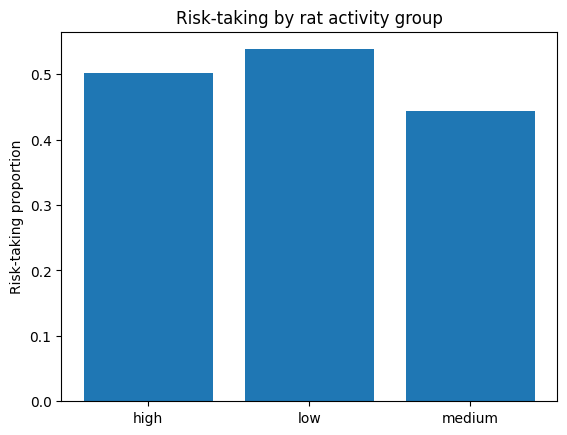

In [41]:
if "risk" in df.columns:
    grp = df.groupby("rat_activity_group")["risk"].mean()
    plt.bar(grp.index, grp.values)
    plt.ylabel("Risk-taking proportion")
    plt.title("Risk-taking by rat activity group")
    plt.show()

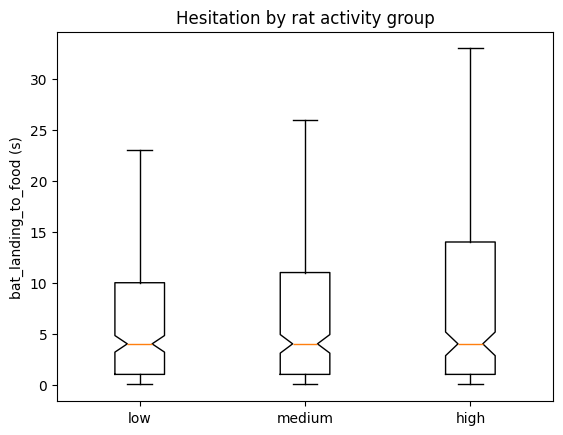

In [42]:
if "bat_landing_to_food" in df.columns:
    groups = [df.loc[df["rat_activity_group"]==g, "bat_landing_to_food"].dropna() for g in df["rat_activity_group"].unique()]
    labels = [str(g) for g in df["rat_activity_group"].unique()]
    plt.boxplot(groups, labels=labels, notch=True, showfliers=False)
    plt.ylabel("bat_landing_to_food (s)")
    plt.title("Hesitation by rat activity group")
    plt.show()

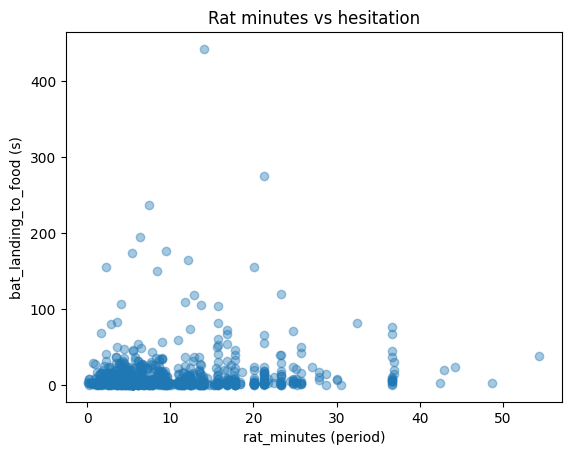

In [43]:
if "bat_landing_to_food" in df.columns:
    plt.scatter(df["rat_minutes"], df["bat_landing_to_food"], alpha=0.4)
    plt.xlabel("rat_minutes (period)")
    plt.ylabel("bat_landing_to_food (s)")
    plt.title("Rat minutes vs hesitation")
    plt.show()

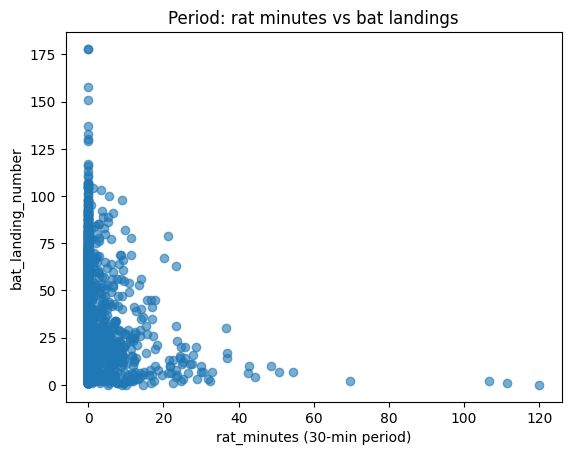

In [44]:
if "rat_minutes" in df2.columns and "bat_landing_number" in df2.columns:
    plt.scatter(df2["rat_minutes"], df2["bat_landing_number"], alpha=0.6)
    plt.xlabel("rat_minutes (30-min period)")
    plt.ylabel("bat_landing_number")
    plt.title("Period: rat minutes vs bat landings")
    plt.show()

In [45]:
# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from IPython.display import display


In [46]:
# Helper functions
def to_dt(x):
    if pd.isna(x): return pd.NaT
    if isinstance(x, (pd.Timestamp, datetime)): return pd.to_datetime(x)
    for fmt in ["%Y-%m-%d %H:%M:%S","%d/%m/%Y %H:%M","%m/%d/%Y %H:%M","%Y/%m/%d %H:%M:%S","%Y-%m-%dT%H:%M:%S","%d-%m-%Y %H:%M"]:
        try: return datetime.strptime(str(x), fmt)
        except Exception: pass
    return pd.to_datetime(x, errors="coerce")

def month_to_int(m):
    if pd.isna(m): return np.nan
    if isinstance(m, (int, np.integer, float, np.floating)):
        if 1 <= int(m) <= 12: return int(m)
        return np.nan
    s = str(m).strip().lower()
    mapping = {
        "jan":1,"january":1,"1":1,"01":1,
        "feb":2,"february":2,"2":2,"02":2,
        "mar":3,"march":3,"3":3,"03":3,
        "apr":4,"april":4,"4":4,"04":4,
        "may":5,"5":5,"05":5,
        "jun":6,"june":6,"6":6,"06":6,
        "jul":7,"july":7,"7":7,"07":7,
        "aug":8,"august":8,"8":8,"08":8,
        "sep":9,"sept":9,"september":9,"9":9,"09":9,
        "oct":10,"october":10,"10":10,
        "nov":11,"november":11,"11":11,
        "dec":12,"december":12,"12":12
    }
    return mapping.get(s, np.nan)

def month_to_season(m_int):
    # Southern Hemisphere mapping; default to Spring if missing/invalid
    if pd.isna(m_int):
        return "Spring"
    m_int = int(m_int)
    if m_int in [12, 1, 2]:
        return "Summer"
    elif m_int in [3, 4, 5]:
        return "Autumn"
    elif m_int in [6, 7, 8]:
        return "Winter"
    else:
        return "Spring"

def ensure_season(df):
    if "season" not in df.columns or df["season"].isna().all():
        if "month" in df.columns:
            m = df["month"].apply(month_to_int)
            df["season"] = m.apply(month_to_season)
        else:
            df["season"] = "Spring"
    order = ["Summer", "Autumn", "Winter", "Spring"]
    df["season"] = pd.Categorical(df["season"].fillna("Spring"), categories=order, ordered=True)
    return df

def describe_by_season(df, col):
    g = df.dropna(subset=["season", col]).groupby("season")[col]
    return g.agg(["count","mean","median","std","min","max"]).reset_index()


In [47]:
# ---- Load dataset2 ----
d2 = pd.read_csv("dataset2.csv")
if "time" in d2.columns: d2["time"] = d2["time"].apply(to_dt)
for c in ["hours_after_sunset","bat_landing_number","food_availability","rat_minutes","rat_arrival_number"]:
    if c in d2.columns: d2[c] = pd.to_numeric(d2[c], errors="coerce")
d2 = ensure_season(d2)

display(d2.head())
print("d2 shape:", d2.shape)


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number,season
0,2017-12-26 16:13:00,0,-0.5,20,4.000000,0.0,0,Spring
1,2017-12-26 16:43:00,0,0.0,28,4.000000,0.0,0,Spring
2,2017-12-26 17:13:00,0,0.5,25,4.000000,0.0,0,Spring
3,2017-12-26 17:43:00,0,1.0,71,4.000000,0.0,0,Spring
4,2017-12-26 18:13:00,0,1.5,44,3.753857,0.0,0,Spring


d2 shape: (2123, 8)


In [48]:
# ---- Load dataset1 ----
d1 = pd.read_csv("dataset1.csv")
for col in ["start_time","rat_period_start","rat_period_end","sunset_time"]:
    if col in d1.columns: d1[col] = d1[col].apply(to_dt)
for c in ["bat_landing_to_food","seconds_after_rat_arrival","risk","reward","hours_after_sunset"]:
    if c in d1.columns: d1[c] = pd.to_numeric(d1[c], errors="coerce")

display(d1.head())
print("d1 shape:", d1.shape)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,2017-12-30 18:37:00,16.000000,rat,2017-12-30 18:35:00,2017-12-30 18:38:00,108,1,0,0,2017-12-30 16:45:00,1.870833,0
1,2017-12-30 19:51:00,0.074016,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,17,0,1,0,2017-12-30 16:45:00,3.100833,0
2,2017-12-30 19:51:00,4.000000,fast,2017-12-30 19:50:00,2017-12-30 19:55:00,41,0,1,0,2017-12-30 16:45:00,3.107500,0
3,2017-12-30 19:52:00,10.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,111,1,0,0,2017-12-30 16:45:00,3.126944,0
4,2017-12-30 19:54:00,15.000000,rat,2017-12-30 19:50:00,2017-12-30 19:55:00,194,1,0,0,2017-12-30 16:45:00,3.150000,0


d1 shape: (907, 12)


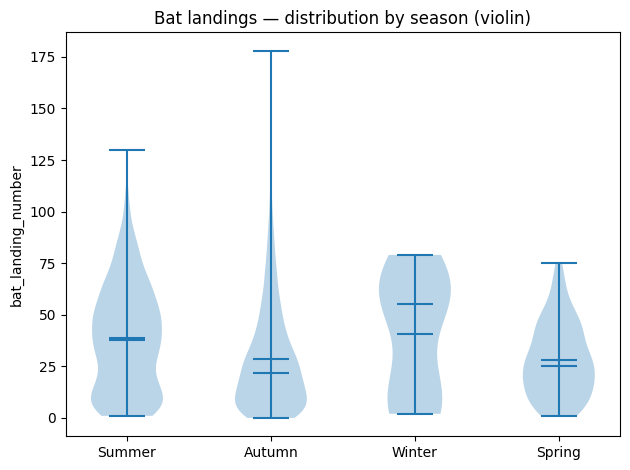

In [49]:
# Cell 1 — Violin plots by season (distribution shape)
if {"season","bat_landing_number"}.issubset(d2.columns) and d2["season"].nunique() >= 2:
    ordered = [s for s in ["Summer","Autumn","Winter","Spring"] if s in d2["season"].astype(str).unique()] 
    data = [d2.loc[d2["season"]==s, "bat_landing_number"].dropna().values for s in ordered]
    if all(len(v)>0 for v in data):
        plt.figure()
        plt.violinplot(data, showmeans=True, showmedians=True)
        plt.xticks(range(1, len(ordered)+1), ordered)
        plt.title("Bat landings — distribution by season (violin)")
        plt.ylabel("bat_landing_number")
        plt.tight_layout()
        plt.show()


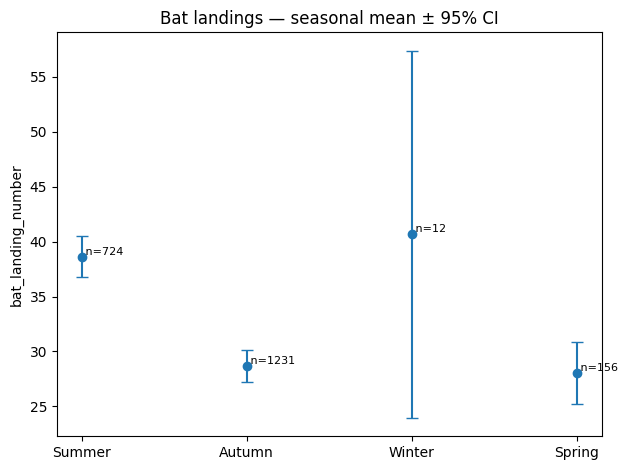

In [50]:
# Cell 2 — Seasonal means with 95% CI (error bars) — FIXED
import numpy as np

def mean_ci(x):
    x = np.asarray(x, float)
    n = x.size
    if n < 2:
        return np.nan, np.nan
    m = np.nanmean(x)
    se = np.nanstd(x, ddof=1) / np.sqrt(n)
    ci = 1.96 * se
    return m, ci

if {"season","bat_landing_number"}.issubset(d2.columns):
    dfp = d2.dropna(subset=["season","bat_landing_number"]).copy()
    if not dfp.empty:
        rows = []
        # observed=False retains current behavior and silences FutureWarning
        for s, grp in dfp.groupby("season", observed=False):
            m, ci = mean_ci(grp["bat_landing_number"].values)
            rows.append({"season": str(s), "mean": m, "ci": ci, "n": len(grp)})

        stats_tbl = pd.DataFrame(rows).dropna(subset=["mean"])
        if not stats_tbl.empty:
            x = np.arange(len(stats_tbl))
            plt.figure()
            plt.errorbar(x, stats_tbl["mean"].values, yerr=stats_tbl["ci"].values, fmt='o', capsize=4)
            plt.xticks(x, stats_tbl["season"].tolist())
            plt.title("Bat landings — seasonal mean ± 95% CI")
            plt.ylabel("bat_landing_number")
            # annotate n
            for i, (m, n) in enumerate(zip(stats_tbl["mean"].values, stats_tbl["n"].values)):
                if np.isfinite(m):
                    plt.text(i, m, f" n={int(n)}", ha="left", va="bottom", fontsize=8)
            plt.tight_layout()
            plt.show()
        else:
            print("No non-empty seasonal groups to plot.")
    else:
        print("No data after dropping NA in [season, bat_landing_number].")
else:
    print("Required columns missing for seasonal means CI plot.")


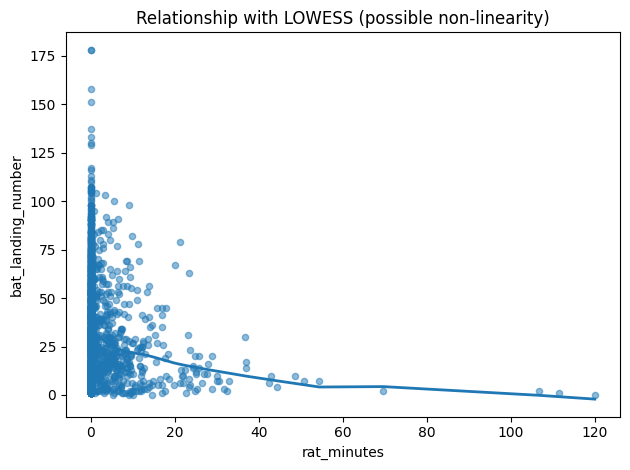

In [51]:
# Cell 3 — Scatter + LOWESS curve (non-linear trend)
from statsmodels.nonparametric.smoothers_lowess import lowess

if {"rat_minutes","bat_landing_number"}.issubset(d2.columns):
    dfp = d2.dropna(subset=["rat_minutes","bat_landing_number"]).copy()
    if len(dfp) > 20:
        plt.figure()
        plt.scatter(dfp["rat_minutes"], dfp["bat_landing_number"], s=20, alpha=0.5)
        smth = lowess(dfp["bat_landing_number"], dfp["rat_minutes"], frac=0.3, return_sorted=True)
        plt.plot(smth[:,0], smth[:,1], linewidth=2)
        plt.xlabel("rat_minutes")
        plt.ylabel("bat_landing_number")
        plt.title("Relationship with LOWESS (possible non-linearity)")
        plt.tight_layout()
        plt.show()


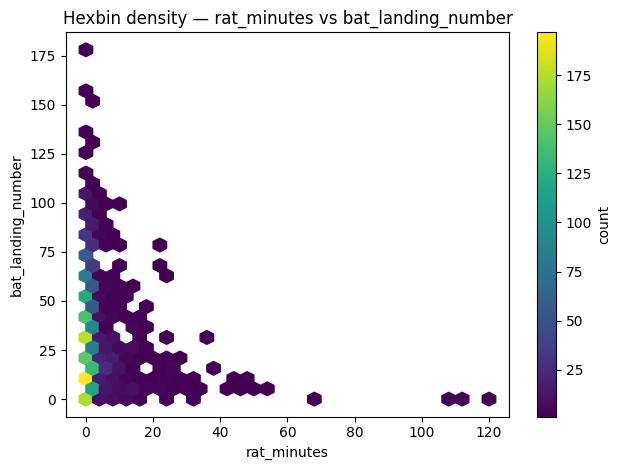

In [52]:
# Cell 4 — Hexbin density (handles large scatter overlap)
if {"rat_minutes","bat_landing_number"}.issubset(d2.columns):
    dfp = d2.dropna(subset=["rat_minutes","bat_landing_number"]).copy()
    if len(dfp) > 0:
        plt.figure()
        hb = plt.hexbin(dfp["rat_minutes"], dfp["bat_landing_number"], gridsize=30, mincnt=1)
        plt.colorbar(hb, label="count")
        plt.xlabel("rat_minutes")
        plt.ylabel("bat_landing_number")
        plt.title("Hexbin density — rat_minutes vs bat_landing_number")
        plt.tight_layout()
        plt.show()


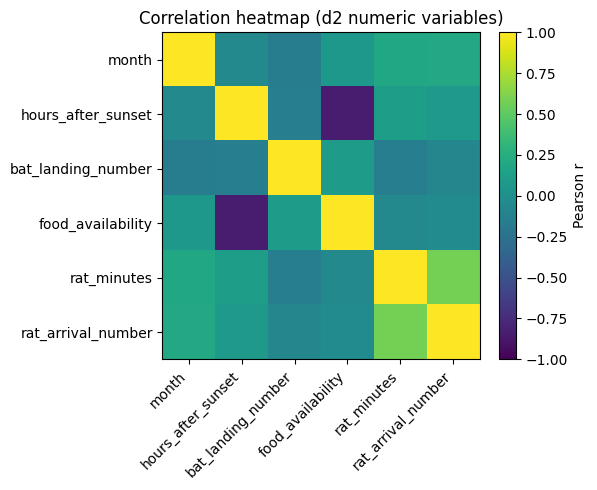

In [53]:
# Cell 5 — Correlation heatmap (numerical columns in d2)
num_cols = d2.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    corr = d2[num_cols].corr(method="pearson")
    plt.figure(figsize=(6,5))
    im = plt.imshow(corr, aspect='auto', vmin=-1, vmax=1)
    plt.colorbar(im, label="Pearson r")
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation heatmap (d2 numeric variables)")
    plt.tight_layout()
    plt.show()


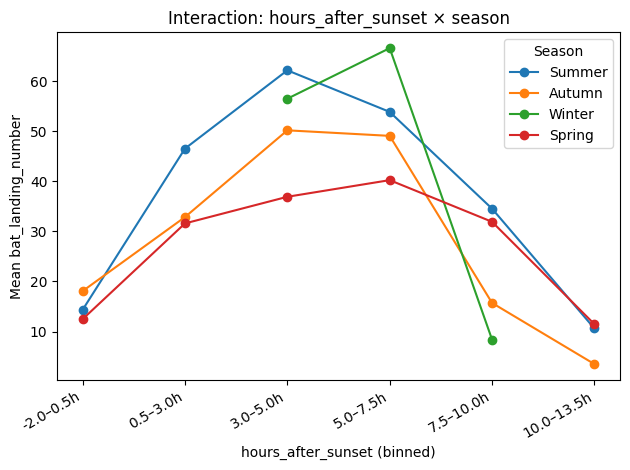

In [54]:
# Cell 6 — Interaction lines: hours_after_sunset × season
if {"season","hours_after_sunset","bat_landing_number"}.issubset(d2.columns):
    dfp = d2.dropna(subset=["season","hours_after_sunset","bat_landing_number"]).copy()
    if not dfp.empty and dfp["season"].nunique() >= 2:
        dfp["hour_bin"] = pd.qcut(dfp["hours_after_sunset"], q=min(6, dfp["hours_after_sunset"].nunique()), duplicates="drop")
        piv = dfp.groupby(["hour_bin","season"])["bat_landing_number"].mean().reset_index()
        ordered_bins = sorted(piv["hour_bin"].unique(), key=lambda x: x.left)
        x = np.arange(len(ordered_bins))
        plt.figure()
        for s in sorted(piv["season"].unique(), key=lambda z: ["Summer","Autumn","Winter","Spring"].index(z) if z in ["Summer","Autumn","Winter","Spring"] else 99):
            y = [piv.loc[(piv["hour_bin"]==b) & (piv["season"]==s), "bat_landing_number"].mean() for b in ordered_bins]
            plt.plot(x, y, marker='o', label=s)
        plt.xticks(x, [f"{b.left:.1f}–{b.right:.1f}h" for b in ordered_bins], rotation=30, ha='right')
        plt.xlabel("hours_after_sunset (binned)")
        plt.ylabel("Mean bat_landing_number")
        plt.title("Interaction: hours_after_sunset × season")
        plt.legend(title="Season")
        plt.tight_layout()
        plt.show()


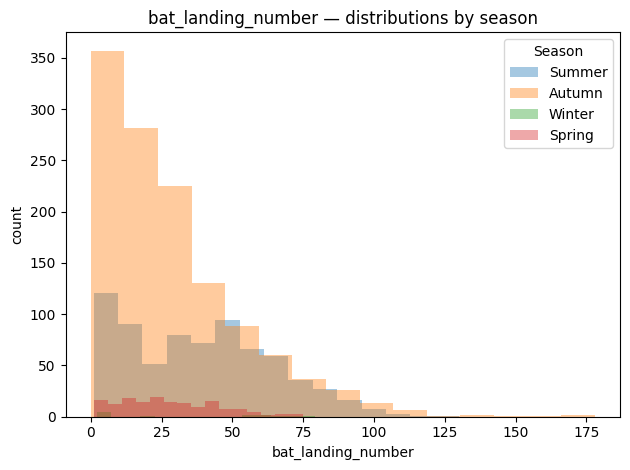

In [55]:
# Cell 7 — Distribution comparison: layered histograms by season
target = "bat_landing_number"
if {"season", target}.issubset(d2.columns):
    ordered = [s for s in ["Summer","Autumn","Winter","Spring"] if s in d2["season"].astype(str).unique()]
    plt.figure()
    for s in ordered:
        vals = d2.loc[d2["season"]==s, target].dropna().values
        if len(vals) > 0:
            plt.hist(vals, bins=15, alpha=0.4, label=s)
    plt.title(f"{target} — distributions by season")
    plt.xlabel(target)
    plt.ylabel("count")
    plt.legend(title="Season")
    plt.tight_layout()
    plt.show()


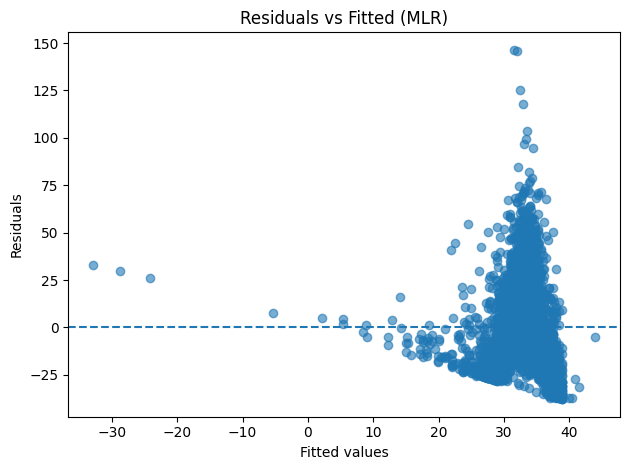

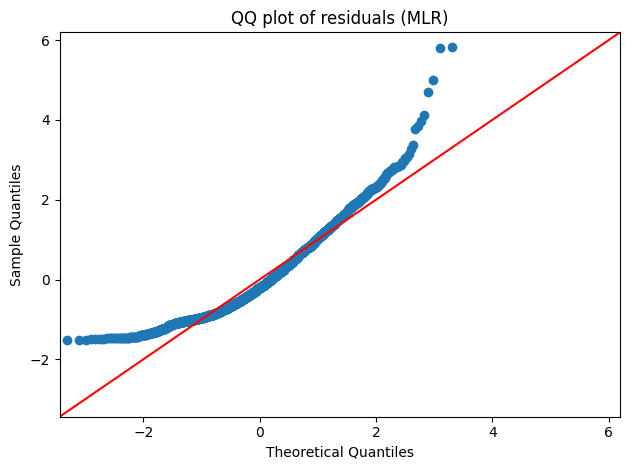

In [56]:
# Cell 8 — Residual diagnostics for Multiple Linear Regression
if "bat_landing_number" in d2.columns:
    predictors = [c for c in ["rat_minutes","rat_arrival_number","hours_after_sunset","food_availability"] if c in d2.columns]
    if predictors:
        df_mlr = d2.dropna(subset=["bat_landing_number"] + predictors).copy()
        if len(df_mlr) > 8:
            X = sm.add_constant(df_mlr[predictors])
            y = df_mlr["bat_landing_number"].values
            m2 = sm.OLS(y, X).fit()
            resid = m2.resid
            fitted = m2.fittedvalues

            plt.figure()
            plt.scatter(fitted, resid, alpha=0.6)
            plt.axhline(0, linestyle='--')
            plt.xlabel("Fitted values")
            plt.ylabel("Residuals")
            plt.title("Residuals vs Fitted (MLR)")
            plt.tight_layout()
            plt.show()

            sm.qqplot(resid, line='45', fit=True)
            plt.title("QQ plot of residuals (MLR)")
            plt.tight_layout()
            plt.show()


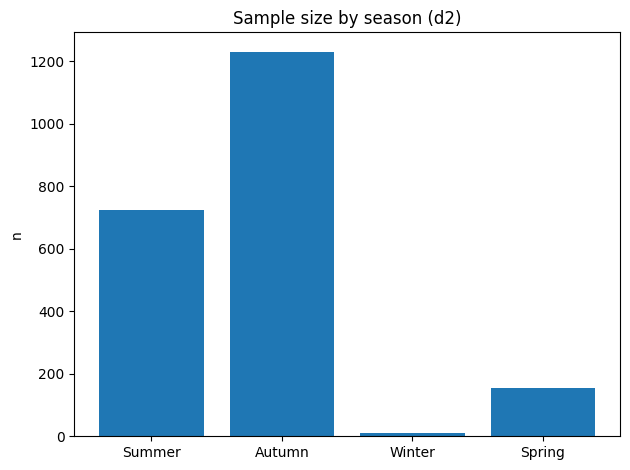

In [57]:
# Cell 9 — Sample size per season (bar chart)
if "season" in d2.columns:
    counts = d2["season"].value_counts().reindex(["Summer","Autumn","Winter","Spring"])
    counts = counts.dropna()
    if counts.sum() > 0:
        plt.figure()
        plt.bar(counts.index.astype(str), counts.values)
        plt.ylabel("n")
        plt.title("Sample size by season (d2)")
        plt.tight_layout()
        plt.show()


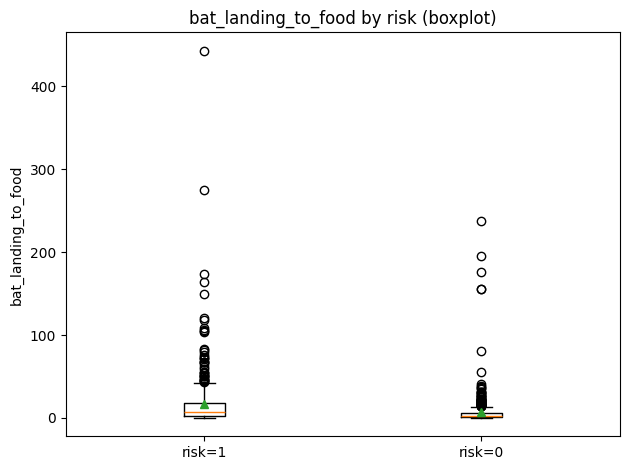

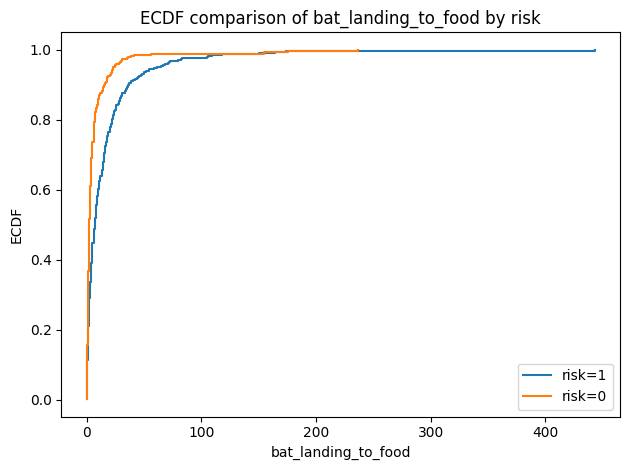

In [58]:
# Cell 10 — d1: bat_landing_to_food by risk — boxplot and ECDF
def ecdf(vals):
    vals = np.sort(np.asarray(vals, float))
    y = np.arange(1, len(vals)+1) / len(vals)
    return vals, y

if {"bat_landing_to_food","risk"}.issubset(d1.columns):
    a = d1.loc[d1["risk"]==1, "bat_landing_to_food"].dropna().values
    b = d1.loc[d1["risk"]==0, "bat_landing_to_food"].dropna().values
    if len(a) > 2 and len(b) > 2:
        plt.figure()
        plt.boxplot([a, b], labels=["risk=1","risk=0"], showmeans=True)
        plt.title("bat_landing_to_food by risk (boxplot)")
        plt.ylabel("bat_landing_to_food")
        plt.tight_layout()
        plt.show()

        xa, ya = ecdf(a)
        xb, yb = ecdf(b)
        plt.figure()
        plt.step(xa, ya, where='post', label="risk=1")
        plt.step(xb, yb, where='post', label="risk=0")
        plt.xlabel("bat_landing_to_food")
        plt.ylabel("ECDF")
        plt.title("ECDF comparison of bat_landing_to_food by risk")
        plt.legend()
        plt.tight_layout()
        plt.show()


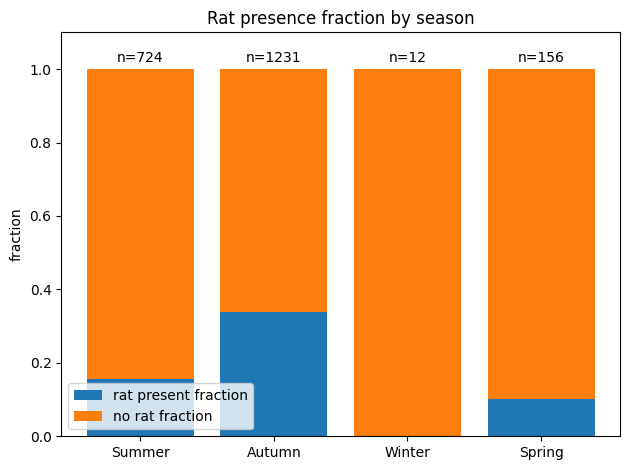

In [59]:
# Cell 11 — Seasonal stacked bars: rat presence vs no-presence
if {"season","rat_minutes"}.issubset(d2.columns):
    dfp = d2.dropna(subset=["season","rat_minutes"]).copy()
    if not dfp.empty:
        dfp["rat_present"] = (dfp["rat_minutes"] > 0).astype(int)
        tab = dfp.pivot_table(index="season", values="rat_present", aggfunc=["mean","count"])
        frac = tab["mean"]["rat_present"]
        n = tab["count"]["rat_present"]
        idx = frac.index.tolist()
        plt.figure()
        plt.bar(idx, frac.values, label="rat present fraction")
        plt.bar(idx, 1-frac.values, bottom=frac.values, label="no rat fraction")
        for i, (f, nn) in enumerate(zip(frac.values, n.values)):
            plt.text(i, 1.02, f"n={int(nn)}", ha="center")
        plt.ylim(0, 1.1)
        plt.ylabel("fraction")
        plt.title("Rat presence fraction by season")
        plt.legend()
        plt.tight_layout()
        plt.show()


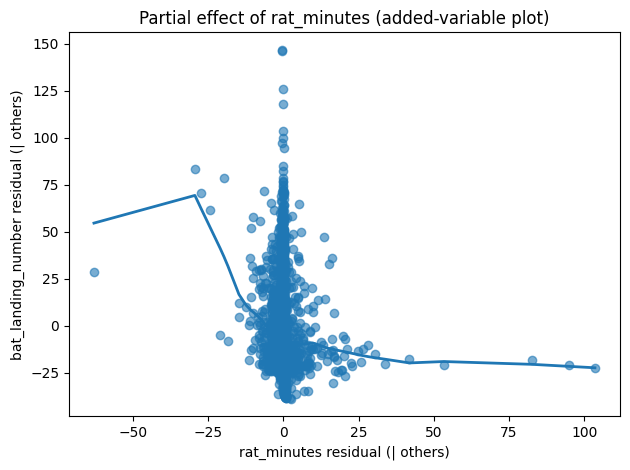

In [60]:
# Cell 12 — Partial residual (added-variable) plot for a key predictor
if "bat_landing_number" in d2.columns:
    predictors = [c for c in ["rat_minutes","rat_arrival_number","hours_after_sunset","food_availability"] if c in d2.columns]
    if "rat_minutes" in predictors and len(predictors) >= 2:
        df_avp = d2.dropna(subset=["bat_landing_number"] + predictors).copy()
        if len(df_avp) > 8:
            X_all = sm.add_constant(df_avp[predictors])
            y = df_avp["bat_landing_number"].values
            model = sm.OLS(y, X_all).fit()

            others = ["rat_arrival_number","hours_after_sunset","food_availability"]
            others = [c for c in others if c in predictors]
            if others:
                X_others = sm.add_constant(df_avp[others])
                y_resid = sm.OLS(y, X_others).fit().resid
                x_resid = sm.OLS(df_avp["rat_minutes"].values, X_others).fit().resid

                plt.figure()
                plt.scatter(x_resid, y_resid, alpha=0.6)
                from statsmodels.nonparametric.smoothers_lowess import lowess
                smth = lowess(y_resid, x_resid, frac=0.3, return_sorted=True)
                plt.plot(smth[:,0], smth[:,1], linewidth=2)
                plt.xlabel("rat_minutes residual (| others)")
                plt.ylabel("bat_landing_number residual (| others)")
                plt.title("Partial effect of rat_minutes (added-variable plot)")
                plt.tight_layout()
                plt.show()


## Part 2 — Simple Regression, Multiple Regression, and Bayes' Rule

Simple Linear Regression: bat_landing_number ~ rat_minutes
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     46.34
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           1.29e-11
Time:                        13:06:04   Log-Likelihood:                -9874.2
No. Observations:                2123   AIC:                         1.975e+04
Df Residuals:                    2121   BIC:                         1.976e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

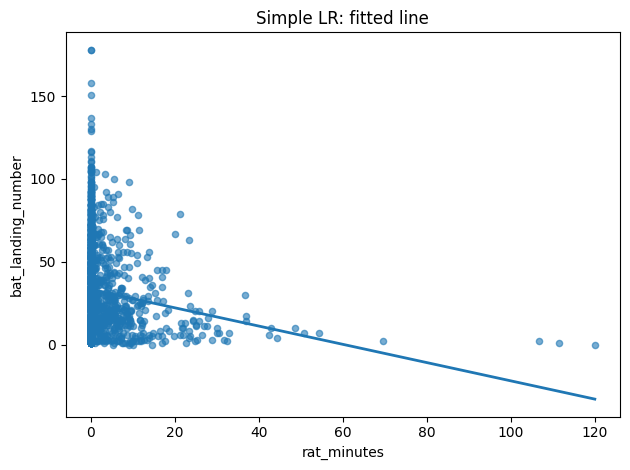

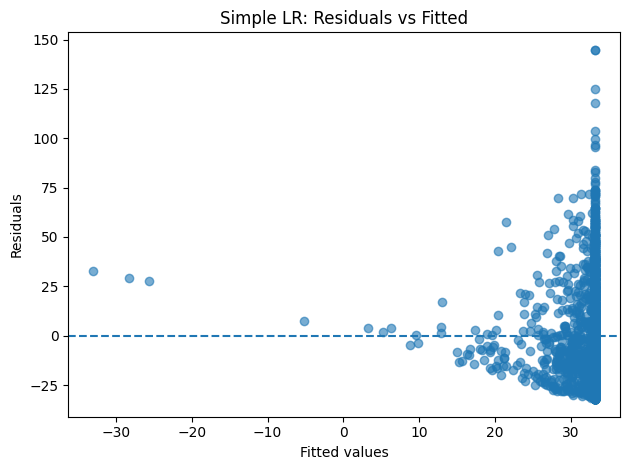

In [61]:
# Simple Linear Regression (Part 2): bat_landing_number ~ rat_minutes
import numpy as np
import statsmodels.api as sm

needed = {"bat_landing_number","rat_minutes"}
if needed.issubset(d2.columns):
    df_lr = d2.dropna(subset=list(needed)).copy()
    if len(df_lr) > 2:
        X = sm.add_constant(df_lr["rat_minutes"].values)
        y = df_lr["bat_landing_number"].values
        m_simple = sm.OLS(y, X).fit()
        print("Simple Linear Regression: bat_landing_number ~ rat_minutes")
        print(m_simple.summary())

        # Scatter + fitted line
        xgrid = np.linspace(df_lr["rat_minutes"].min(), df_lr["rat_minutes"].max(), 200)
        Xg = sm.add_constant(xgrid)
        yg = m_simple.predict(Xg)

        plt.figure()
        plt.scatter(df_lr["rat_minutes"], df_lr["bat_landing_number"], s=20, alpha=0.6)
        plt.plot(xgrid, yg, linewidth=2)
        plt.xlabel("rat_minutes")
        plt.ylabel("bat_landing_number")
        plt.title("Simple LR: fitted line")
        plt.tight_layout()
        plt.show()

        # Residuals vs Fitted
        fitted = m_simple.fittedvalues
        resid = m_simple.resid
        plt.figure()
        plt.scatter(fitted, resid, alpha=0.6)
        plt.axhline(0, linestyle="--")
        plt.xlabel("Fitted values")
        plt.ylabel("Residuals")
        plt.title("Simple LR: Residuals vs Fitted")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough observations after dropping NAs for simple regression.")
else:
    print(f"Missing columns for simple regression: {needed - set(d2.columns)}")


Multiple Linear Regression: bat_landing_number ~ rat_minutes + rat_arrival_number + hours_after_sunset + food_availability
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     20.66
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           1.01e-16
Time:                        13:06:04   Log-Likelihood:                -9856.5
No. Observations:                2123   AIC:                         1.972e+04
Df Residuals:                    2118   BIC:                         1.975e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]


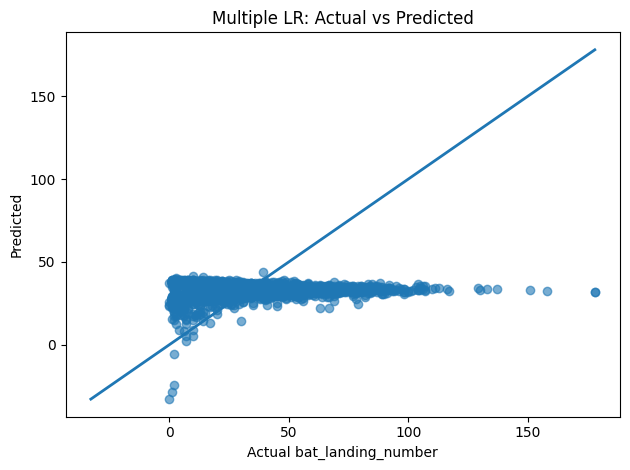

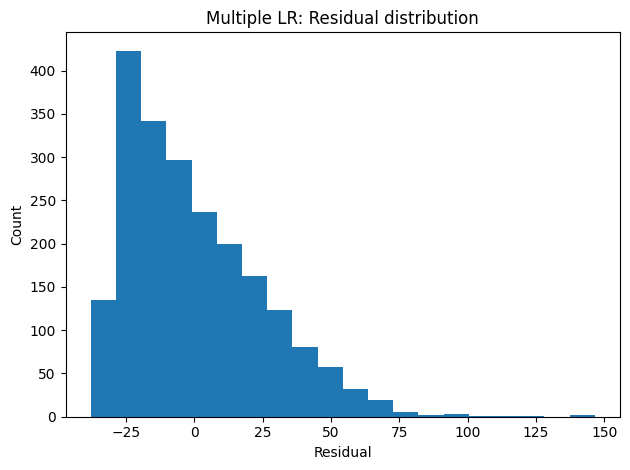

In [62]:
# Multiple Linear Regression (Part 2): bat_landing_number ~ rat_minutes + rat_arrival_number + hours_after_sunset + food_availability
import numpy as np
import statsmodels.api as sm

predictors_all = [c for c in ["rat_minutes","rat_arrival_number","hours_after_sunset","food_availability"] if c in d2.columns]
if "bat_landing_number" in d2.columns and predictors_all:
    df_mlr = d2.dropna(subset=["bat_landing_number"] + predictors_all).copy()
    if len(df_mlr) > 8:
        X = sm.add_constant(df_mlr[predictors_all])
        y = df_mlr["bat_landing_number"].values
        m_multi = sm.OLS(y, X).fit()
        print("Multiple Linear Regression: bat_landing_number ~", " + ".join(predictors_all))
        print(m_multi.summary())

        # Actual vs Predicted
        yhat = m_multi.fittedvalues
        plt.figure()
        plt.scatter(y, yhat, alpha=0.6)
        lims = [min(y.min(), yhat.min()), max(y.max(), yhat.max())]
        plt.plot(lims, lims, linewidth=2)
        plt.xlabel("Actual bat_landing_number")
        plt.ylabel("Predicted")
        plt.title("Multiple LR: Actual vs Predicted")
        plt.tight_layout()
        plt.show()

        # Residual histogram
        resid = m_multi.resid
        plt.figure()
        plt.hist(resid, bins=20)
        plt.xlabel("Residual")
        plt.ylabel("Count")
        plt.title("Multiple LR: Residual distribution")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough observations after dropping NAs for multiple regression.")
else:
    print("Required columns are missing for multiple regression.")


Bayes' Rule on dataset2 (median threshold for High bat landings)
n = 2123
P(A=HighBat)     = 0.4913
P(B=RatPresent)  = 0.2567
P(B|A)           = 0.2023
Bayes P(A|B)     = 0.3872
Empirical P(A|B) = 0.3872


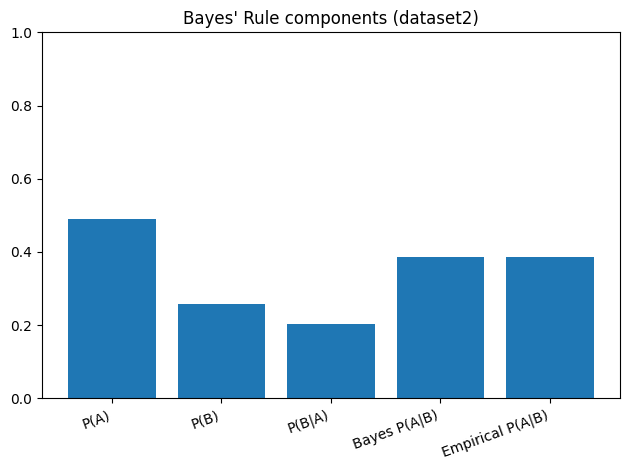

In [63]:
# Bayes' Rule (Part 2): Using dataset2 to estimate P(HighBat | RatPresent)
#   A = High bat landings (above median)
#   B = Rat present (rat_minutes > 0)
# P(A|B) = P(B|A) * P(A) / P(B)
import numpy as np
import pandas as pd

if {"bat_landing_number","rat_minutes"}.issubset(d2.columns):
    dfb = d2.dropna(subset=["bat_landing_number","rat_minutes"]).copy()
    if not dfb.empty:
        median_bat = dfb["bat_landing_number"].median()
        dfb["A_high_bat"] = (dfb["bat_landing_number"] > median_bat).astype(int)
        dfb["B_rat_present"] = (dfb["rat_minutes"] > 0).astype(int)

        P_A = dfb["A_high_bat"].mean()
        P_B = dfb["B_rat_present"].mean()
        P_B_given_A = dfb.loc[dfb["A_high_bat"]==1, "B_rat_present"].mean() if (dfb["A_high_bat"]==1).sum() > 0 else np.nan
        P_A_given_B_bayes = (P_B_given_A * P_A) / P_B if (P_B and not np.isnan(P_B_given_A)) else np.nan
        P_A_given_B_emp = dfb.loc[dfb["B_rat_present"]==1, "A_high_bat"].mean() if (dfb["B_rat_present"]==1).sum() > 0 else np.nan

        print("Bayes' Rule on dataset2 (median threshold for High bat landings)")
        print(f"n = {len(dfb)}")
        print(f"P(A=HighBat)     = {P_A:.4f}")
        print(f"P(B=RatPresent)  = {P_B:.4f}")
        print(f"P(B|A)           = {P_B_given_A:.4f}")
        print(f"Bayes P(A|B)     = {P_A_given_B_bayes:.4f}")
        print(f"Empirical P(A|B) = {P_A_given_B_emp:.4f}")

        labels = ["P(A)", "P(B)", "P(B|A)", "Bayes P(A|B)", "Empirical P(A|B)"]
        vals = [P_A, P_B, P_B_given_A, P_A_given_B_bayes, P_A_given_B_emp]
        plt.figure()
        plt.bar(labels, vals)
        plt.ylim(0, 1)
        plt.title("Bayes' Rule components (dataset2)")
        plt.xticks(rotation=20, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No data rows available for Bayes' calculation after dropping NAs.")
else:
    print("Required columns for Bayes' rule are missing.")


In [64]:
chi2 = np.nan

if {"risk","reward"}.issubset(d1.columns):
    ct = pd.crosstab(d1["risk"], d1["reward"])
    if ct.values.sum() > 0:
        chi2_res = stats.chi2_contingency(ct.fillna(0).values)
        chi2, p, dof, expected = chi2_res
        print("\nChi-square (risk vs reward):")
        print(f"chi2={chi2:.3f}, p={p:.4g}, dof={dof}")




Chi-square (risk vs reward):
chi2=352.834, p=1.023e-78, dof=1
